# Zillow Clustering Project Explore Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import os
from env import host, user, password
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import math

from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

import acquire
import prepare
import explore
import warnings
warnings.filterwarnings('ignore')

In [2]:
# connect to database, perform SQL query, write to csv, and convert to pandas DataFrame
df = acquire.get_zillow_cluster()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52438 entries, 0 to 52437
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   storytypeid                   47 non-null     float64
 2   propertylandusetypeid         52438 non-null  float64
 3   heatingorsystemtypeid         33934 non-null  float64
 4   buildingclasstypeid           0 non-null      float64
 5   architecturalstyletypeid      70 non-null     float64
 6   airconditioningtypeid         13638 non-null  float64
 7   parcelid                      52438 non-null  int64  
 8   id                            52438 non-null  int64  
 9   basementsqft                  47 non-null     float64
 10  bathroomcnt                   52438 non-null  float64
 11  bedroomcnt                    52438 non-null  float64
 12  buildingqualitytypeid         33739 non-null  float64
 13  c

In [4]:
df = prepare.zillow_prep(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51897 entries, 14297519 to 12826780
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   51897 non-null  float64
 1   bedroomcnt                    51897 non-null  float64
 2   calculatedbathnbr             51897 non-null  float64
 3   calculatedfinishedsquarefeet  51897 non-null  float64
 4   fips                          51897 non-null  float64
 5   fullbathcnt                   51897 non-null  float64
 6   latitude                      51897 non-null  float64
 7   longitude                     51897 non-null  float64
 8   lotsizesquarefeet             51897 non-null  float64
 9   roomcnt                       51897 non-null  float64
 10  taxamount                     51897 non-null  float64
 11  logerror                      51897 non-null  float64
 12  LA                            51897 non-null  uint

In [6]:
col_list = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude',
       'longitude', 'lotsizesquarefeet', 'roomcnt', 'taxamount', 'logerror', 'age', 'taxrate', 'acres', 'bath_bed_ratio',]
df = prepare.drop_outliers(df, col_list, k=3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41458 entries, 14297519 to 12826780
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   41458 non-null  float64
 1   bedroomcnt                    41458 non-null  float64
 2   calculatedbathnbr             41458 non-null  float64
 3   calculatedfinishedsquarefeet  41458 non-null  float64
 4   fips                          41458 non-null  float64
 5   fullbathcnt                   41458 non-null  float64
 6   latitude                      41458 non-null  float64
 7   longitude                     41458 non-null  float64
 8   lotsizesquarefeet             41458 non-null  float64
 9   roomcnt                       41458 non-null  float64
 10  taxamount                     41458 non-null  float64
 11  logerror                      41458 non-null  float64
 12  LA                            41458 non-null  uint

In [8]:
# now let's split our clean data
train, \
validate, \
test, \
X_train, \
y_train,\
X_validate, \
y_validate, \
X_test, \
y_test = prepare.train_validate_test(df, 'logerror')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23216 entries, 10949178 to 14142774
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   23216 non-null  float64
 1   bedroomcnt                    23216 non-null  float64
 2   calculatedbathnbr             23216 non-null  float64
 3   calculatedfinishedsquarefeet  23216 non-null  float64
 4   fips                          23216 non-null  float64
 5   fullbathcnt                   23216 non-null  float64
 6   latitude                      23216 non-null  float64
 7   longitude                     23216 non-null  float64
 8   lotsizesquarefeet             23216 non-null  float64
 9   roomcnt                       23216 non-null  float64
 10  taxamount                     23216 non-null  float64
 11  logerror                      23216 non-null  float64
 12  LA                            23216 non-null  uint

In [10]:
train.nunique()

bathroomcnt                        10
bedroomcnt                          6
calculatedbathnbr                  10
calculatedfinishedsquarefeet     3183
fips                                3
fullbathcnt                         5
latitude                        22815
longitude                       22842
lotsizesquarefeet                7837
roomcnt                            14
taxamount                       22870
logerror                        23144
LA                                  2
Orange                              2
Ventura                             2
age                               128
taxrate                         23165
acres                            7837
bath_bed_ratio                     25
dtype: int64

In [11]:
# # time to impute...

# train = prepare.impute_zillow(train, 'most_frequent', ['calculatedbathnbr', 'fullbathcnt', 'age', 'taxrate', 'taxamount', 'acres'])
# X_train = prepare.impute_zillow(train, 'most_frequent', ['calculatedbathnbr', 'fullbathcnt', 'age', 'taxrate', 'taxamount', 'acres'])
# train = prepare.impute_zillow(train, 'median', ['calculatedfinishedsquarefeet',  'lotsizesquarefeet'])
# X_train = prepare.impute_zillow(X_train, 'median', ['calculatedfinishedsquarefeet',  'lotsizesquarefeet'])

In [12]:
list(train)

['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'fips',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'roomcnt',
 'taxamount',
 'logerror',
 'LA',
 'Orange',
 'Ventura',
 'age',
 'taxrate',
 'acres',
 'bath_bed_ratio']

In [62]:
variables = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 
             'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet', 'roomcnt', 'taxamount',
             'age', 'taxrate', 'acres']

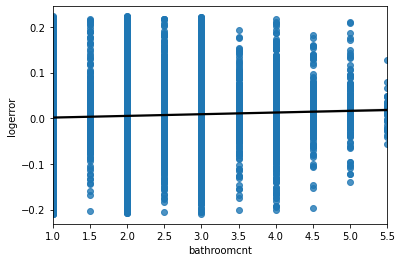

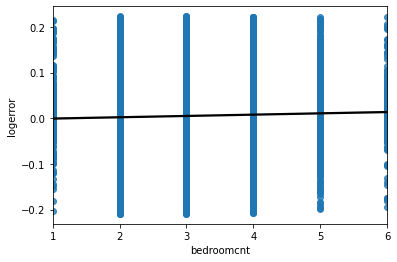

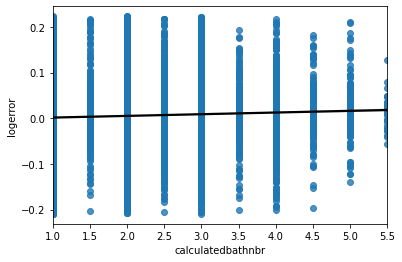

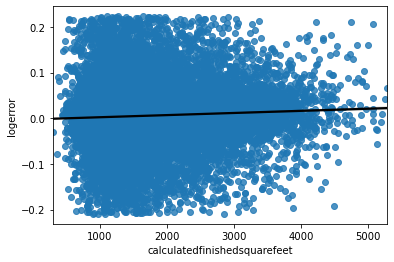

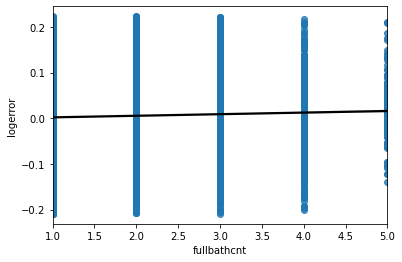

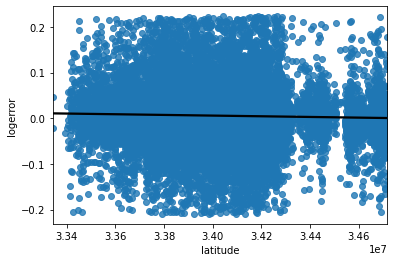

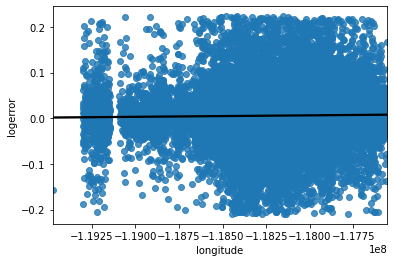

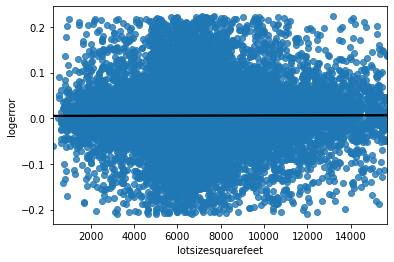

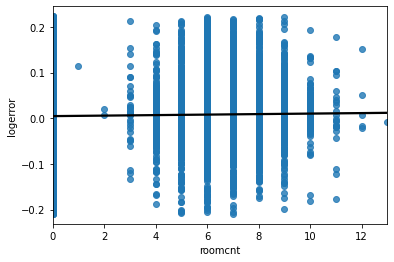

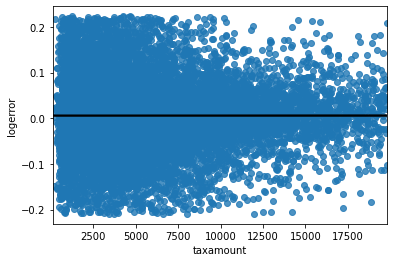

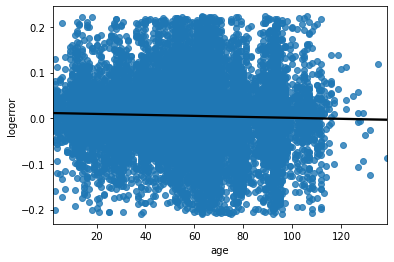

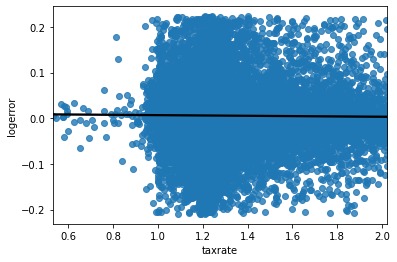

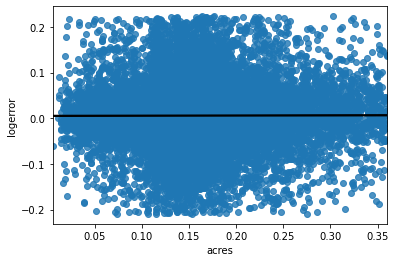

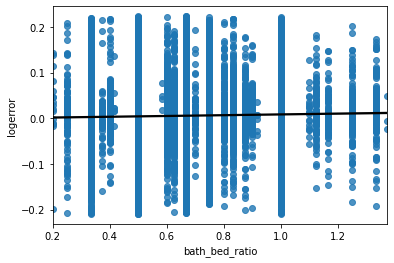

In [14]:
explore.plot_vars_target(train, 'logerror', variables)

### Takeaways:
- The widest range of logerror appears to be on lower-middle class properties
    - most variables have widest range of logerror at lower end of variable range
    - bed, bath, sqft, etc have greatest error at their respective lower ends
- I would like to be able to use latitude and longitude to create neighborhood variables
- Plenty of exploration still left to do, and no clear cut drivers of error at this point...

## Hypothosis Testing

### Hypothesis 1:
- ${H_O}$: There is no difference in mean logerror between bathroomcnt <=1, and mean logerror of all bathroom counts.
- ${H_a}$: There is a difference in mean logerror between bathroomcnt <=1, and mean logerror of all bathroom counts.
- alpha = 0.05

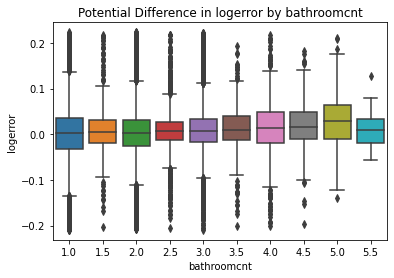

In [15]:
sns.boxplot(train.bathroomcnt, train.logerror)
plt.title('Potential Difference in logerror by bathroomcnt')
plt.show()

In [16]:
# How does variance compare among these groups?
stats.levene(train[train.bathroomcnt<=1].logerror, train[train.bathroomcnt>1].logerror)

LeveneResult(statistic=231.60487210411523, pvalue=4.750386535702109e-52)

In [17]:
# Now to run a ttest to compare mean logerrors
stats.ttest_ind(train[train.bathroomcnt <= 1].logerror, train[train.bathroomcnt > 1].logerror, equal_var=False)

Ttest_indResult(statistic=-3.1767992990722886, pvalue=0.0014970494308213307)

#### Hypothesis 1 Takeaways:
- Due to leven test, we see vairance is not equal among these groups
- Since my p-value is greater than alpha, we fail to reject the null hypothesis

### Hypothesis 2:
- ${H_O}$: There is no difference in mean logerror between bedroomcnt <=3, and mean logerror of bedroomcnt > 3.
- ${H_a}$: There is a difference in mean logerror between bedroomcnt <=3, and mean logerror of bedroomcnt > 3.
- alpha = 0.05

In [18]:
# How does variance compare among these groups?
stats.levene(train[train.bedroomcnt<=1].logerror, train[train.bedroomcnt>1].logerror)

LeveneResult(statistic=23.153535788395875, pvalue=1.5050715790605365e-06)

In [19]:
# Now to run a ttest to compare mean logerrors
stats.ttest_ind(train[train.bedroomcnt <= 3].logerror, train[train.bedroomcnt > 3].logerror, equal_var=False)

Ttest_indResult(statistic=-5.011974266866272, pvalue=5.436061009114765e-07)

#### Hypothesis 2 Takeaways:
- Due to Levene test, we see vairance is not equal among these groups
- Since my p-value is less than alpha, we can reject the null hypothesis
- Evidence to suggest bedroomcnt could be a good feature for modeling

### Hypothesis 3:
- ${H_O}$: There is no relationship between latitude and logerror, (they are independent variables.)
- ${H_a}$: There is a relationship between latitude and logerror, (they are dependent variables.)
- alpha = 0.05

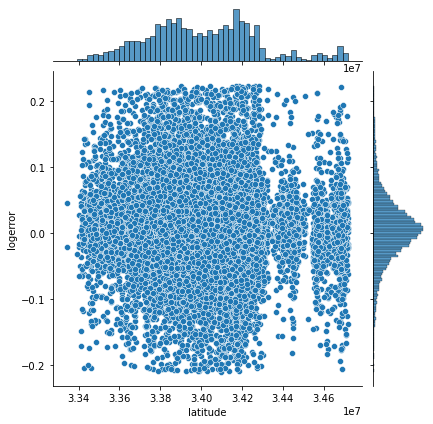

In [20]:
sns.jointplot(x='latitude', y='logerror', data=train)
plt.xlabel('Latitude')
plt.ylabel('Logerror')
plt.show()

In [21]:
r, p = stats.pearsonr(train.latitude, train.logerror)
r, p

(-0.03286150836686675, 5.496301282742366e-07)

#### Hypothesis 3 Takeaways:
- Since my p-value is less than alpha, we can reject the null hypothesis
- However, due to a very low correlation coefficient (r), there does not appear to be evidence to suggest linear relationship between latitude and logerror
- Evidence to suggest latitude could be a good feature for modeling, if used in conjunction with other features

### Hypothesis 4:
- ${H_O}$: There is no relationship between longitude and logerror, (they are independent variables.)
- ${H_a}$: There is a relationship between longitude and logerror, (they are dependent variables.)
- alpha = 0.05

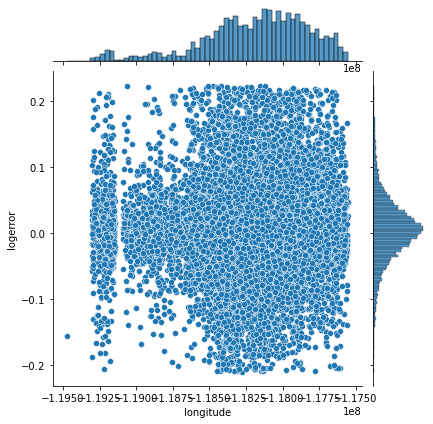

In [22]:
sns.jointplot(x='longitude', y='logerror', data=train)
plt.xlabel('Longitude')
plt.ylabel('Logerror')
plt.show()

In [23]:
r, p = stats.pearsonr(train.longitude, train.logerror)
r, p

(0.019309324578167524, 0.0032584879070059513)

#### Hypothesis 4 Takeaways:
- Since my p-value is less than alpha, we can reject the null hypothesis
- However, due to a very low correlation coefficient (r), there does not appear to be evidence to suggest linear relationship between longitude and logerror
- Evidence to suggest longitude could be a good feature for modeling, if used in conjunction with other features

### Clustering

In [24]:
# scale my data...
train_scaled, \
validate_scaled, \
test_scaled = explore.Standard_Scaler(train, validate, test)

In [25]:
X_train_scaled = train_scaled.drop(columns='logerror')
X_validate_scaled = validate_scaled.drop(columns='logerror')
X_test_scaled = test_scaled.drop(columns='logerror')

In [26]:
y_train_scaled = train_scaled['logerror']
y_validate_scaled = validate_scaled['logerror']
y_test_scaled = test_scaled['logerror']

#### cluster_alpha

In [27]:
X0_train = X_train[['age', 'latitude', 'longitude']]
X0_train_scaled, stan_scaler = explore.scale_my_data(X0_train, StandardScaler())

X0_validate = X_validate[['age', 'latitude', 'longitude']]
X0_validate_scaled, stan_scaler = explore.scale_my_data(X0_validate, StandardScaler())

X0_test = X_test[['age', 'latitude', 'longitude']]
X0_test_scaled, stan_scaler = explore.scale_my_data(X0_test, StandardScaler())


In [28]:
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=3, random_state = 1221)

# fit the thing
kmeans.fit(X0_train_scaled)

# Use (predict using) the thing 
kmeans.predict(X0_train_scaled)

array([0, 0, 1, ..., 2, 0, 1], dtype=int32)

In [29]:
# make a new column names cluster in iris and X_scaled dataframe
train['cluster_alpha'] = kmeans.predict(X0_train_scaled)

X0_train_scaled['cluster_alpha'] = kmeans.predict(X0_train_scaled)
X0_validate_scaled['cluster_alpha'] = kmeans.predict(X0_validate_scaled)
X0_test_scaled['cluster_alpha'] = kmeans.predict(X0_test_scaled)

In [30]:
# Make a dataframe 
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X0_train.columns)
centroids_scaled

,age,latitude,longitude
0,0.825435,0.008408,-0.047596
1,-0.633858,-0.926274,0.912224
2,-0.644726,1.265739,-1.174071


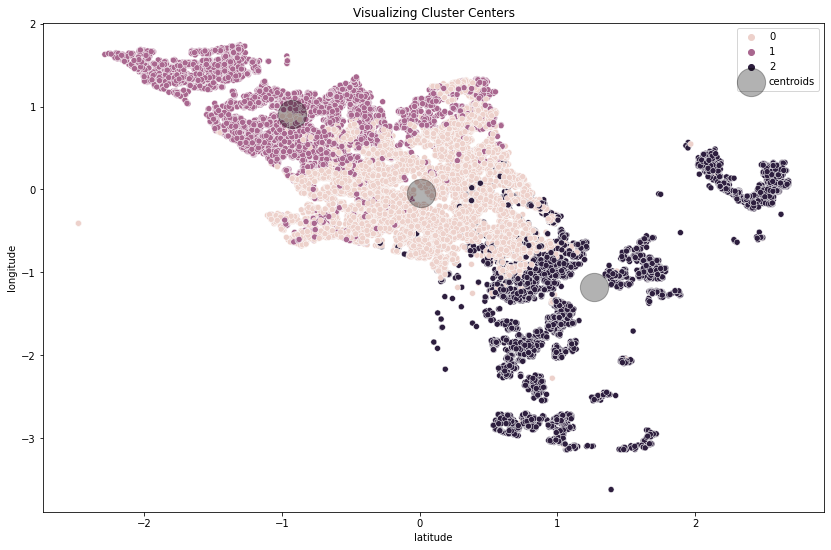

In [31]:
# lets visualize the clusters along with the centers on scaled data.

plt.figure(figsize=(14, 9))

# scatter plot of data with hue for cluster
sns.scatterplot(x = 'latitude', y = 'longitude', data = X0_train_scaled, hue = 'cluster_alpha')

# plot cluster centers (centroids)
centroids_scaled.plot.scatter(x= 'latitude', y = 'longitude', 
                              ax = plt.gca(), 
                              s = 800, color = 'k', 
                              alpha = 0.3, 
                              label = 'centroids')

plt.title('Visualizing Cluster Centers')
plt.legend();

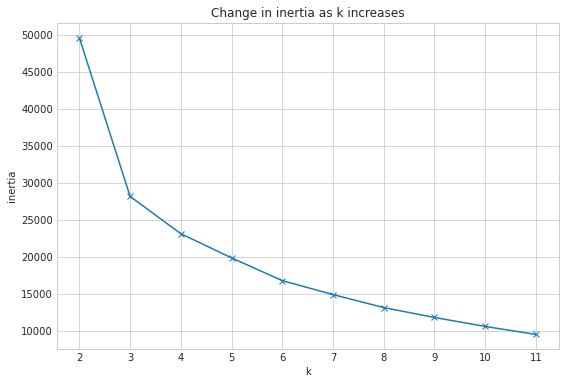

In [32]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X0_train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

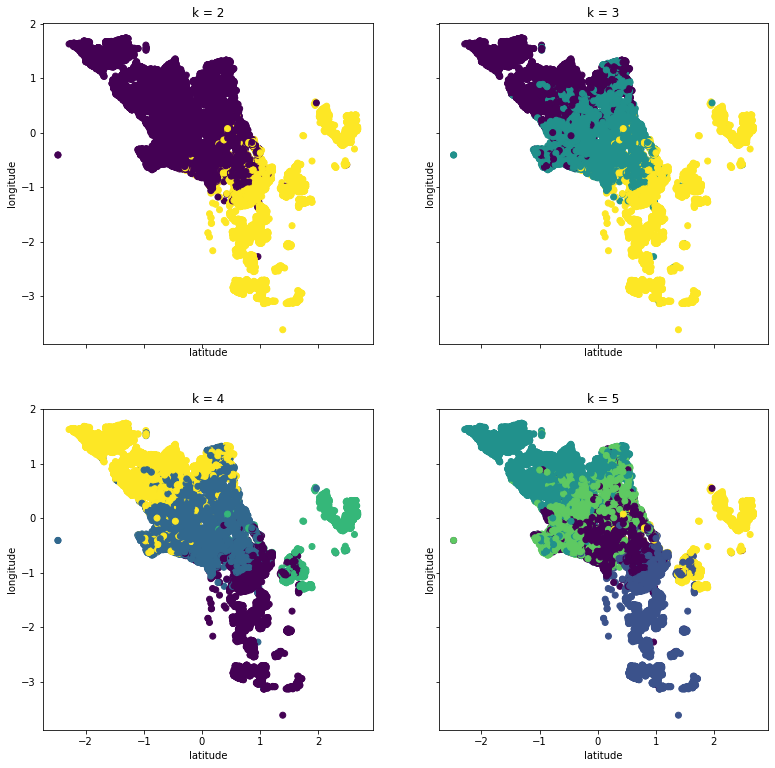

In [33]:
# What value of k is appropriate?


fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X0_train_scaled).predict(X0_train_scaled)
    ax.scatter(X0_train_scaled.latitude, X0_train_scaled.longitude, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='latitude', ylabel='longitude')

In [34]:
# create subsets for clusters
alpha_0 = train[train.cluster_alpha == 0].logerror
alpha_1 = train[train.cluster_alpha == 1].logerror
alpha_2 = train[train.cluster_alpha == 2].logerror

In [35]:
# drop 'cluster' column in order to add centroids to modeling subsets
X0_train_scaled = X0_train_scaled.drop(columns='cluster_alpha')
X0_validate_scaled = X0_validate_scaled.drop(columns='cluster_alpha')
X0_test_scaled = X0_test_scaled.drop(columns='cluster_alpha')

In [36]:
X_train_scaled['cluster_alpha'] = kmeans.predict(X0_train_scaled)
X_validate_scaled['cluster_alpha'] = kmeans.predict(X0_validate_scaled)
X_test_scaled['cluster_alpha'] = kmeans.predict(X0_test_scaled)

In [37]:
# run ANOVA test to determine if logerror is equal across all clusters
null_hypothesis = 'the logerror is the same across all 3 clusters.'
alt_hypothesis = 'the logerror is different in the clusters.'

alpha = 0.05

f, p = stats.f_oneway(alpha_0, alpha_1, alpha_2)
f, p

(33.03364281840229, 4.721155793354348e-15)

In [38]:
if p < alpha:
    print('Can reject the null hypothesis that', null_hypothesis)
    print('There is evidence to support that', alt_hypothesis)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', null_hypothesis)

Can reject the null hypothesis that the logerror is the same across all 3 clusters.
There is evidence to support that the logerror is different in the clusters.


#### cluster_alpha takeways:
- 3 or 4 clusters appears to be the way to go...
- While intertia is lower on 4 clusters, 3 might provide less overfitting
- Both (3,4) are worth exploring further...

#### cluster_bravo

In [50]:
X1_train = train[['calculatedfinishedsquarefeet', 'age']]
X1_train_scaled, stan_scaler = explore.scale_my_data(X1_train, StandardScaler())

X1_validate = validate[['calculatedfinishedsquarefeet', 'age']]
X1_validate_scaled, stan_scaler = explore.scale_my_data(X1_validate, StandardScaler())

X1_test = test[['calculatedfinishedsquarefeet', 'age']]
X1_test_scaled, stan_scaler = explore.scale_my_data(X1_test, StandardScaler())

In [51]:
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=4, random_state = 1221)

# fit the thing
kmeans.fit(X1_train_scaled)

# Use (predict using) the thing 
kmeans.predict(X1_train_scaled)

array([1, 3, 2, ..., 3, 3, 0], dtype=int32)

In [52]:
# make a new column names cluster in iris and X_scaled dataframe
train['cluster_bravo'] = kmeans.predict(X1_train_scaled)

X1_train_scaled['cluster_bravo'] = kmeans.predict(X1_train_scaled)
X1_validate_scaled['cluster_bravo'] = kmeans.predict(X1_validate_scaled)
X1_test_scaled['cluster_bravo'] = kmeans.predict(X1_test_scaled)

In [53]:
# Make a dataframe 
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X1_train.columns)
centroids_scaled

,calculatedfinishedsquarefeet,age
0,1.920263,-1.218092
1,-0.600191,0.326739
2,0.247910,-0.695006
3,-0.460108,1.606139


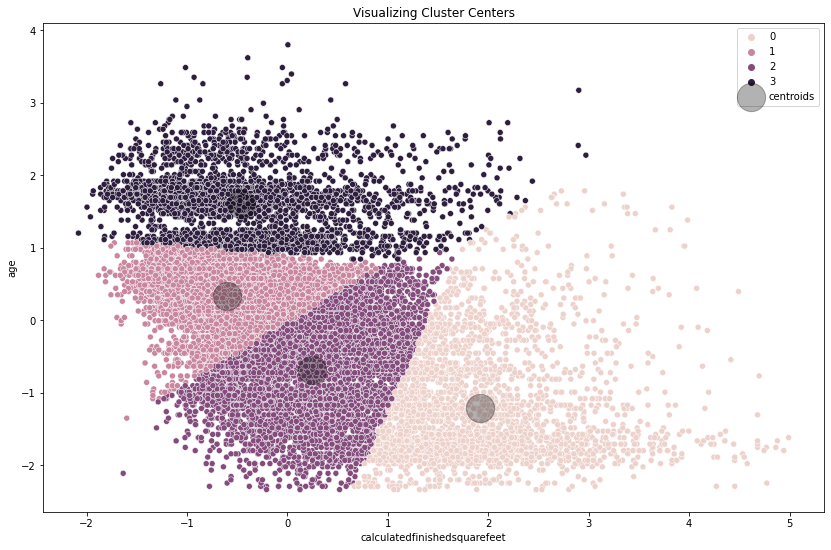

In [54]:
# lets visualize the clusters along with the centers on scaled data.

plt.figure(figsize=(14, 9))

# scatter plot of data with hue for cluster
sns.scatterplot(x = 'calculatedfinishedsquarefeet', y = 'age', data = X1_train_scaled, hue = 'cluster_bravo')

# plot cluster centers (centroids)
centroids_scaled.plot.scatter(x= 'calculatedfinishedsquarefeet', y = 'age', 
                              ax = plt.gca(), 
                              s = 800, color = 'k', 
                              alpha = 0.3, 
                              label = 'centroids')

plt.title('Visualizing Cluster Centers')
plt.legend();

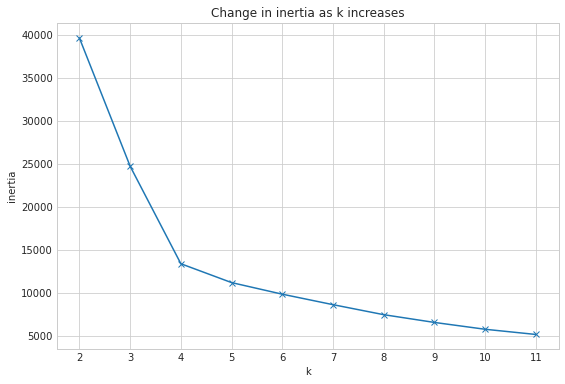

In [55]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X1_train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

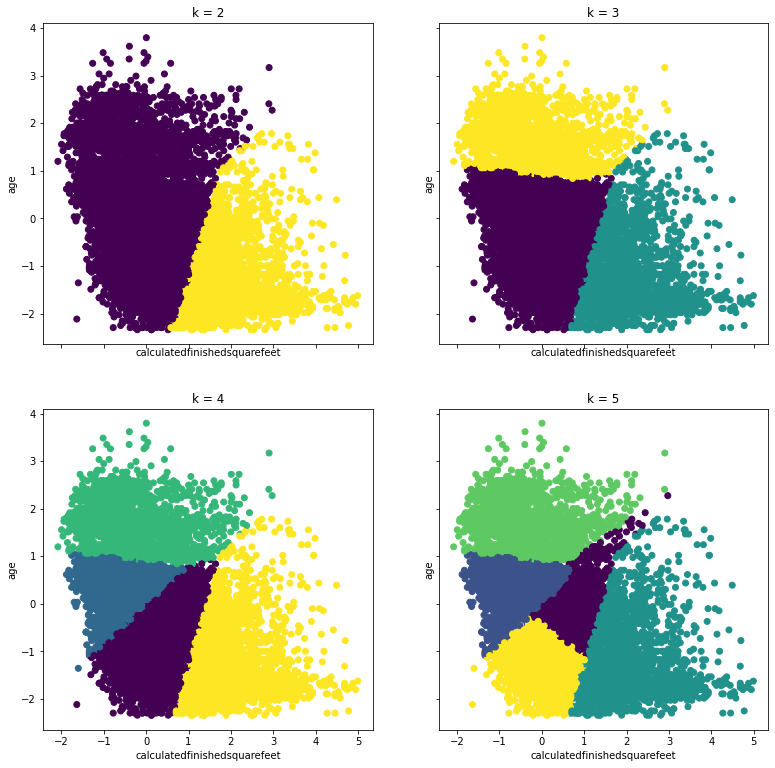

In [56]:
# What value of k is appropriate?


fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X1_train_scaled).predict(X1_train_scaled)
    ax.scatter(X1_train_scaled.calculatedfinishedsquarefeet, X1_train_scaled.age, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='calculatedfinishedsquarefeet', ylabel='age')

In [57]:
# create subsets for clusters
bravo_0 = train[train.cluster_bravo == 0].logerror
bravo_1 = train[train.cluster_bravo == 1].logerror
bravo_2 = train[train.cluster_bravo == 2].logerror
bravo_3 = train[train.cluster_bravo == 3].logerror

In [58]:
# drop 'cluster' column in order to add centroids to modeling subsets
X1_train_scaled = X1_train_scaled.drop(columns='cluster_bravo')
X1_validate_scaled = X1_validate_scaled.drop(columns='cluster_bravo')
X1_test_scaled = X1_test_scaled.drop(columns='cluster_bravo')

In [ ]:
# run ANOVA test to determine if logerror is equal across all clusters
null_hypothesis = 'the logerror is the same across all 3 clusters.'
alt_hypothesis = 'the logerror is different in the clusters.'

alpha = 0.05

f, p = stats.f_oneway(bravo_0, bravo_1, bravo_2, bravo_3)
f, p

In [ ]:
if p < alpha:
    print('Can reject the null hypothesis that', null_hypothesis)
    print('There is evidence to support that', alt_hypothesis)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', null_hypothesis)

#### cluster_bravo takeways:
- 3 or 4 clusters appears to be the way to go...
- although 5 is interesting as well (might be overfit, might be great...)
- 3, 4, and 5 all worth exploring further on beta

#### cluster_charlie

In [ ]:
X2_train = train[['bedroomcnt', 'bathroomcnt', 'taxrate']]

X2_train_scaled, stan_scaler = explore.scale_my_data(X2_train, StandardScaler())

In [ ]:
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=3, random_state = 1221)

# fit the thing
kmeans.fit(X2_train_scaled)

# Use (predict using) the thing 
kmeans.predict(X2_train_scaled)

In [ ]:
# make a new column names cluster in iris and X_scaled dataframe
train['cluster_charlie'] = kmeans.predict(X2_train_scaled)

X2_train_scaled['cluster_charlie'] = kmeans.predict(X2_train_scaled)

In [ ]:
# Make a dataframe 
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X2_train.columns)
centroids_scaled

In [ ]:
# lets visualize the clusters along with the centers on scaled data.

plt.figure(figsize=(14, 9))

# scatter plot of data with hue for cluster
sns.scatterplot(x = 'bedroomcnt', y = 'taxrate', data = X2_train_scaled, hue = 'cluster_charlie')

# plot cluster centers (centroids)
centroids_scaled.plot.scatter(x= 'bedroomcnt', y = 'taxrate', 
                              ax = plt.gca(), 
                              s = 800, color = 'k', 
                              alpha = 0.3, 
                              label = 'centroids')

plt.title('Visualizing Cluster Centers')
plt.legend();

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2_train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
# What value of k is appropriate?


fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X2_train_scaled).predict(X2_train_scaled)
    ax.scatter(X2_train_scaled.bedroomcnt, X2_train_scaled.taxrate, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='bedroomcnt', ylabel='taxrate')

In [ ]:
# create subsets for clusters
charlie_0 = train[train.cluster_charlie == 0].logerror
charlie_1 = train[train.cluster_charlie == 1].logerror
charlie_2 = train[train.cluster_charlie == 2].logerror

In [ ]:
# run ANOVA test to determine if logerror is equal across all clusters
null_hypothesis = 'the logerror is the same across all 3 clusters.'
alt_hypothesis = 'the logerror is different in the clusters.'

alpha = 0.05

f, p = stats.f_oneway(charlie_0, charlie_1, charlie_2)
f, p

In [ ]:
if p < alpha:
    print('Can reject the null hypothesis that', null_hypothesis)
    print('There is evidence to support that', alt_hypothesis)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', null_hypothesis)

#### cluster_charlie takeways:
- 3 or 4 clusters appears to be the way to go...
- looks like 4 gives the best groupings

#### cluster_delta

In [ ]:
X3_train = train[['latitude', 'longitude', 'taxrate']]

X3_train_scaled, stan_scaler = explore.scale_my_data(X3_train, StandardScaler())

In [ ]:
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=5, random_state = 1221)

# fit the thing
kmeans.fit(X3_train_scaled)

# Use (predict using) the thing 
kmeans.predict(X3_train_scaled)

In [ ]:
# make a new column names cluster in iris and X_scaled dataframe
train['cluster_delta'] = kmeans.predict(X3_train_scaled)

X3_train_scaled['cluster_delta'] = kmeans.predict(X3_train_scaled)

In [ ]:
# Make a dataframe 
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X3_train.columns)
centroids_scaled

In [ ]:
# lets visualize the clusters along with the centers on scaled data.

plt.figure(figsize=(14, 9))

# scatter plot of data with hue for cluster
sns.scatterplot(x = 'latitude', y = 'longitude', data = X3_train_scaled, hue = 'cluster_delta')

# plot cluster centers (centroids)
centroids_scaled.plot.scatter(x= 'latitude', y = 'longitude', 
                              ax = plt.gca(), 
                              s = 800, color = 'k', 
                              alpha = 0.3, 
                              label = 'centroids')

plt.title('Visualizing Cluster Centers')
plt.legend();

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3_train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
# What value of k is appropriate?


fig, axs = plt.subplots(2, 3, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 8)):
    clusters = KMeans(k).fit(X3_train_scaled).predict(X3_train_scaled)
    ax.scatter(X3_train_scaled.latitude, X3_train_scaled.longitude, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='latitude', ylabel='longitude')

In [ ]:
# create subsets for clusters
delta_0 = train[train.cluster_delta == 0].logerror
delta_1 = train[train.cluster_delta == 1].logerror
delta_2 = train[train.cluster_delta == 2].logerror
delta_3 = train[train.cluster_delta == 3].logerror
delta_4 = train[train.cluster_delta == 4].logerror

In [ ]:
# run ANOVA test to determine if logerror is equal across all clusters
null_hypothesis = 'the logerror is the same across all 3 clusters.'
alt_hypothesis = 'the logerror is different in the clusters.'

alpha = 0.05

f, p = stats.f_oneway(delta_0, delta_1, delta_2, delta_3, delta_4)
f, p

In [ ]:
if p < alpha:
    print('Can reject the null hypothesis that', null_hypothesis)
    print('There is evidence to support that', alt_hypothesis)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', null_hypothesis)

#### cluster_delta takeways:
- 3 or 4 clusters appears to be the way to go...
- looks like 4 gives the best groupings

### Clustering Takeaways:


### Modeling

In [ ]:
# let's find the baseline logerror...
train.logerror.mean()

#### Linear Regression (OLM)

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# Predict av_pred_mean
av_pred_mean = y_train['logerror'].mean()
y_train['baseline'] = av_pred_mean
y_validate['baseline'] = av_pred_mean
y_test['baseline'] = av_pred_mean

# RMSE of av_pred_mean
rmse_train = mean_squared_error(y_train['logerror'], y_train['baseline']) ** 0.5
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate['baseline']) ** 0.5

# How did the baseline mean perform
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

In [ ]:
# Clean it up now
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate.round(4),
    'r^2_validate': explained_variance_score(y_validate['logerror'], y_validate['baseline'])}])
metric_df

In [ ]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train['logerror'])

# predict train
y_train['baseline'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train['logerror'], y_train['baseline']) ** (1/2)
# predict validate
y_validate['baseline'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate['baseline']) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
metric_df = metric_df.append(
    {
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate['logerror'], y_validate['baseline'])}, ignore_index=True)
metric_df

### LassoLars

In [63]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train['logerror'])

# predict train
y_train['baseline'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train['logerror'], y_train['baseline']) ** 0.5

# predict validate
y_validate['baseline'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate['baseline']) ** 0.5

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

KeyError: 'logerror'

In [ ]:
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate['logerror'], y_validate['baseline'])}, ignore_index=True)
metric_df

In [61]:
X_train_scaled.head().T

parcel_id,10949178,11703299,14179366,12161700,13939268
bathroomcnt,-0.212874,-1.447472,-0.212874,-0.212874,-0.212874
bedroomcnt,-0.312057,-1.479616,-0.312057,-0.312057,-1.479616
calculatedbathnbr,-0.212874,-1.447472,-0.212874,-0.212874,-0.212874
calculatedfinishedsquarefeet,-0.510601,-0.998400,-0.323422,-0.246849,0.011231
fips,-0.604388,-0.604388,0.440412,-0.604388,0.440412
fullbathcnt,-0.134193,-1.402685,-0.134193,-0.134193,-0.134193
latitude,0.688210,-0.002416,-0.473174,0.753300,-0.852469
longitude,-0.410314,-0.385083,0.893446,0.106784,0.995942
lotsizesquarefeet,-0.033757,-0.671943,0.113332,-0.167583,2.462725
roomcnt,-0.636429,-0.636429,1.565840,-0.636429,1.251230
